<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-set-up-functions" data-toc-modified-id="Imports-and-set-up-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and set-up functions</a></span></li><li><span><a href="#Define-the-PDE-for-Sub-Surface-Temperature-(SST)" data-toc-modified-id="Define-the-PDE-for-Sub-Surface-Temperature-(SST)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define the PDE for Sub-Surface Temperature (SST)</a></span><ul class="toc-item"><li><span><a href="#Implement-SST-PDE" data-toc-modified-id="Implement-SST-PDE-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Implement SST PDE</a></span></li></ul></li><li><span><a href="#Simulate-Data-Using-PDE-Solver" data-toc-modified-id="Simulate-Data-Using-PDE-Solver-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simulate Data Using PDE Solver</a></span></li></ul></div>

# Imports and set-up functions

In [7]:
import os
import pde
import numpy

In [4]:
def dataDir(x):
    cwd = os.getcwd()
    
    return cwd + x 

# Define the PDE for Sub-Surface Temperature (SST)

From (Bézenac, Pajot, and Gallinari, 2019), Equation 3 (p. 2) gives the PDE for advection-diffusion: 

$\begin{equation}
\frac{\del I}{\del t} + (\omega . \grad)I = D\laplace I
\tag{1}
\label{eq1}
\end{equation}$

where $\omega$ is the motion vector $\frac{\Delta x}{\Delta t}$, $D$ is the diffusion coefficient, $\grad$ denotes the gradient operator, and $\laplace$ denotes the Laplacian operator.


To implement this PDE in Python we use the library `py-pde` (docs [here](https://py-pde.readthedocs.io/en/latest/)). Although there are given methods for solving diffusion equations, we will need to implement a custom PDE for the advection-diffusion equation defined in $\eqref{eq1}$.

## Implement SST PDE

In [44]:
# TESTING understanding: KS PDE

from pde import PDEBase

class KuramotoSivashinskyPDE(PDEBase):

    def __init__(self, diffusivity=1, bc="auto_periodic_neumann", bc_laplace="auto_periodic_neumann"):
        """ initialize the class with a diffusivity and boundary conditions
        for the actual field and its second derivative """
        self.diffusivity = diffusivity
        self.bc = bc
        self.bc_laplace = bc_laplace

    def evolution_rate(self, state, t=0):
        """ numpy implementation of the evolution equation """
        state_lapacian = state.laplace(bc=self.bc)
        state_gradient = state.gradient(bc=self.bc)
        return (- state_lapacian.laplace(bc=self.bc_laplace)
                - state_lapacian
                - 0.5 * self.diffusivity * (state_gradient @ state_gradient))

  0%|          | 0/10.0 [00:00<?, ?it/s]

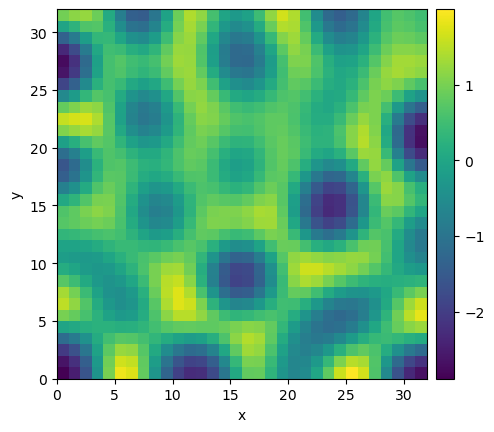

In [45]:
from pde import VectorField, ScalarField, UnitGrid
import random

random.seed(42)

grid = UnitGrid([32, 32])  # generate grid
state = ScalarField.random_uniform(grid)  # generate initial condition
motion = VectorField.random_uniform(grid)

eq = KuramotoSivashinskyPDE()  # define the pde
result = eq.solve(state, t_range=10, dt=0.01)
result.plot()

In [82]:
from pde import PDEBase

class AdvectionDiffusionPDE(PDEBase):
    
    # TODO: diffusion, D, is a matrix?
    # TODO: motion (omega)?
    # TODO: use eq. 2 or eq. 3 in paper?
    # TODO: check boundary conditions
    
    def __init__(self, motion, D=1):
        self.motion=motion
        self.D = D
        self.bc = {"value": 0}  # test
    
    def evolution_rate(self, state, t=0):
        """implement the python version of the evolution equation"""
        
        state_grad = state.gradient(bc={"value": 1.5})
        state_lap = state.laplace(bc={"value": 1.5})
        state_lap2 = state_lap.laplace(bc={"value": 1.5})

        return ((self.D * state_lap2) - (self.motion @ state_grad)) 

In [83]:
# test

from pde import VectorField, ScalarField, UnitGrid, PlotTracker
import random

random.seed(42)

grid = pde.CartesianGrid([[-10, 10], [-10, 10]], 32)
state = pde.ScalarField.from_expression(grid, 'exp(-x**2-y**2)')
motion = pde.VectorField.from_expression(grid, ['1', '1']) # omega

#eq = pde.PDE({'c': 'laplace(c) - dot(motion, gradient(c))'}, 
#             consts={'motion': motion})

eq = AdvectionDiffusionPDE(motion=motion)

storage = pde.MemoryStorage()

trackers = [
    "progress",  # show progress bar during simulation
    "steady_state",  # abort when steady state is reached
    storage.tracker(interval=1),  # store data every simulation time unit
    pde.PlotTracker(show=True),  # show images during simulation
    # print some output every 5 real seconds:
    pde.PrintTracker(interval=pde.RealtimeInterrupts(duration=5)),
]

result = eq.solve(state, t_range=10, dt=0.01, tracker=trackers)

for field in storage:
    print(field.integral)

  0%|          | 0/10.0 [00:00<?, ?it/s]

Output()

t=0, c=0.00785±0.0622
t=0.04, c=-0.606±8.46
t=0.14, c=-4.6e+05±5.66e+07
t=1.69, c=-2.76e+115±1.24e+118


/home/lucia/anaconda3/envs/ml-pde/lib/python3.9/site-packages/pde/fields/base.py:499: RuntimeWarning: invalid value encountered in subtract
  op(self.data, other.data, out=result.data)


ValueError: zero-size array to reduction operation maximum which has no identity

https://py-pde.readthedocs.io/en/latest/manual/advanced_usage.html#custom-pde-classes
https://github.com/zwicker-group/py-pde/discussions/206
https://github.com/zwicker-group/py-pde/discussions?discussions_q=diffusion

# Simulate Data Using PDE Solver

For this step, we use the PDE solver `py-pde` and the instructions from [here](https://pypi.org/project/py-pde/).

In [ ]:
grid = pde.UnitGrid(64, 64)                 # generate a grid
init = pde.ScalarField.random_uniform(grid) # generate initial conditions on the grid

